In [1]:
%load_ext autoreload

In [2]:
# !pip install wandb
# import wandb

%autoreload 2
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Our fancy new modules
import subgrid_parameterization.arch.ann as ann
import subgrid_parameterization.preprocess.SAM_helpers as sam
from subgrid_parameterization.preprocess.torch_helpers import split_dataset
from subgrid_parameterization.util.earlystopper import EarlyStopper
import subgrid_parameterization.util.plot_helpers as plot_helpers

from subgrid_parameterization.preprocess.C14 import get_C14
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length

import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [3]:
path0 = '/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/'

# path = 'sam-bomex/'
# file = 'BOMEX_64x64x75_100m_40m_1s'
# save = 'C14profiles_BOMEX'
# file = 'BOMEX_3d'

path = 'sam-rf01/'
file = 'DYCOMS_RF01_96x96x320'
save = 'C14profiles_DYCOMS'
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

ds=xr.open_dataset(path0+path+file+'.nc')

In [4]:
nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)

In [5]:
L, Lup, Ldown = get_mixing_length(ds)

In [6]:
Hscale=1000 # 1km to normalize mixing lengths which are bounded by  ~40 m and ~3km

In [7]:
C14=get_C14(ds)

In [8]:
up2 = sam.stagger_var('U2',ds)
vp2 = sam.stagger_var('V2',ds)
wp2 = sam.stagger_var('W2',ds)
e = 0.5 * ( up2 + vp2 + wp2)

In [9]:
input = list()
output = list()
for k in range(nzt):
    if not (C14[:,k]==0).all():        
        for it in range(ngrdcol):
            input.append([up2[it, k] / e[it, k],up2[it, k] / e[it, k], up2[it, k] / e[it, k], Lup[it, k]/Hscale, Ldown[it, k]/Hscale])
            output.append([C14[it,k]])
print(str(len(input))+' samples')

35760 samples


In [10]:
# input = []
# output = []
# input = np.hstack([ up2 / e, vp2 / e, wp2 / e, Lup/Hscale, Ldown/Hscale ])

In [11]:
dycoms_dataset = Data.TensorDataset(torch.tensor(input), torch.tensor(output))

In [12]:
train_dataset,test_dataset = split_dataset(dycoms_dataset,0.2) #random_split(bomex_dataset,[0.8,0.2]) returns a Subset so doesn't work later

In [13]:
_,C14train = train_dataset.tensors
# np.array([numerator/(np.std(np.array(output)[:,i])) for i in range(np.array(output).shape[1])])
lossweights= np.ones(C14train.detach().numpy().shape[1])

In [14]:
config={
    "batch_size":360,
    "lr":0.001,      ## learning rate
    "wd":0.01,       ## weight decay
    "epochs":2000,     ## Setting this to a high number because early stopping
    # "subsample":10,   ## Take a subsample of 1000 data points
    "patience":20   ## Patience for early stopping
    }

beta1 = 0.5
beta2 = 0.999

In [15]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [16]:
## Construct training and validation dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
valid_loader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

## Record number of training/validation images
# config["training_fields"]=len(pyqg_dataset.test_idx)
# config["validation_fields"]=len(pyqg_dataset.valid_idx)

In [17]:
nvars = 5 # ups,vp2,wp2,Lup,Ldown
iso = True
if iso:
    nvarsout = 1
else:
    nvarsout = 2
    
N = [nvars,8,4,nvarsout]

try:
    del model
    model=ann.ANN(N).double() ## NN architecture: could be FCNN, resnet, ANN.. etc
except:
    model=ann.ANN(N).double() ## NN architecture: could be FCNN, resnet, ANN.. etc
    
model.to(device)
config["learnable parameters"]=sum(p.numel() for p in model.parameters())

optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], )#weight_decay=config["wd"], betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)
criterion=nn.MSELoss()
early_stopper = EarlyStopper(patience=config["patience"], min_delta=0)

In [18]:
# wandb.init(project="wandb_demo", entity="m2lines",config=config)
# wandb.watch(model, log_freq=1)

In [19]:
train_loss=list()
test_loss=list()
weights=torch.from_numpy(lossweights).to(device)
for epoch in range(config["epochs"]):
    train_samples = 0
    train_running_loss = 0.0
    valid_running_loss = 0.0
    valid_samples = 0
    
    model.train()
    for data in train_loader:
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        ## zero the parameter gradients
        optimizer.zero_grad()
        
        output = model(x_data) ## Takes in Q, outputs \hat{S}
        loss = criterion(output*weights, y_data*weights)
        loss.backward()
        optimizer.step()

        ## Store loss values
        train_running_loss+=loss.detach()*x_data.shape[0]
        train_samples+=x_data.shape[0]
    train_running_loss/=train_samples
    
    model.eval()
    for data in valid_loader:
        x_data, y_data = data
        x_data=x_data.to(device)
        y_data=y_data.to(device)
    
        optimizer.zero_grad()
        output = model(x_data) ## Takes in Q, outputs \hat{S}
        val_loss = criterion(output, y_data)
        ## Store loss values
        valid_running_loss+=val_loss.detach()*x_data.shape[0]
        valid_samples+=x_data.shape[0]
    valid_running_loss/=valid_samples
    
    early_stop=early_stopper.early_stop(valid_running_loss)
    if early_stop:
        print('Early stopping epoch: '+str(epoch-early_stopper.patience)) # +/- 1?
        break
    else:
        torch.save(model.state_dict(),save+'.pt')
    

    # ## Push loss values for each epoch to wandb
    log_dic={}
    log_dic["epoch"]=epoch
    log_dic["training_loss"]=(train_running_loss/train_samples).cpu().numpy()
    log_dic["valid_loss"]=(valid_running_loss/valid_samples).cpu().numpy()
    # wandb.log(log_dic)
    train_loss.append((train_running_loss/train_samples).cpu().numpy())
    test_loss.append((valid_running_loss/valid_samples).cpu().numpy())
    
    # verbose
    # print('%03d %.3e %.3e ' %(log_dic["epoch"], log_dic["training_loss"], log_dic["valid_loss"]), end='')
    # print("")
model.load_state_dict(torch.load(save+'.pt'))#,map_location=device),strict=False)

Early stopping epoch: 159


/glade/derecho/scratch/adac/tmp/ipykernel_100903/1285363730.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save+'.pt'))#,map_location=

<All keys matched successfully>

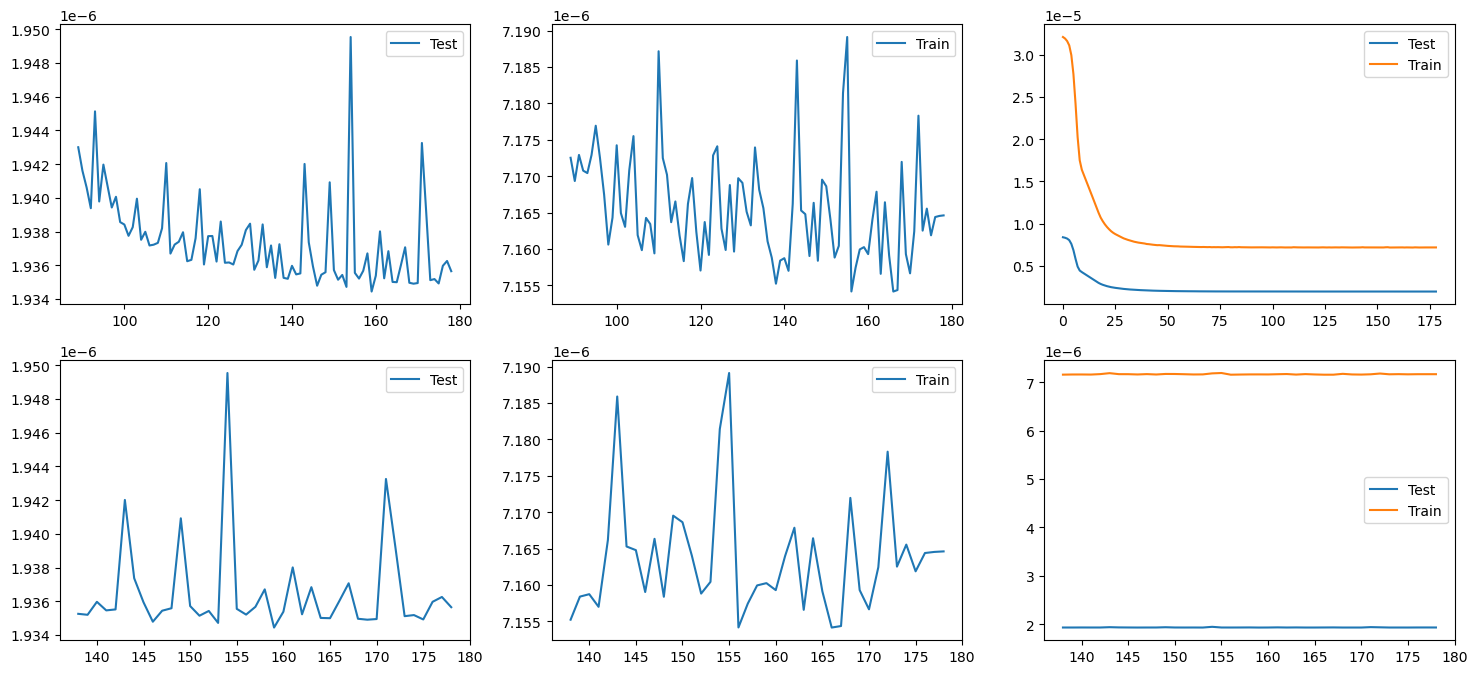

In [20]:
cutStartPct=0.5
zoomEndEpochs=2*early_stopper.patience
plot_helpers.plot_losses([test_loss,train_loss],['Test','Train'],cutStartPct,zoomEndEpochs)

In [21]:
x_test, y_test = test_dataset.tensors
# x_test=x_test.to(device)
y_test=y_test.squeeze().detach().cpu().numpy()
y_pred=model(x_test).squeeze().detach().cpu().numpy()

In [22]:
y_text=r'$C_{14}$'
# r2=np.empty(nzt)
# r=np.empty(nzt)
# for k in range(nzt):
#     r2[k]=r2_score(y_test[:,k], y_pred[:,k])
#     r[k]=np.corrcoef(y_test[:,k], y_pred[:,k])[0, 1]
r2=r2_score(y_test, y_pred)
r=np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for "+y_text)
print("R^2: %.4f" % np.mean(r2) )
print("Correlation: %.4f" % +np.mean(r)+"\n")

Statistics for $C_{14}$
R^2: 0.6110
Correlation: 0.7820



Text(0.5, 1.0, '$C_{14}$')

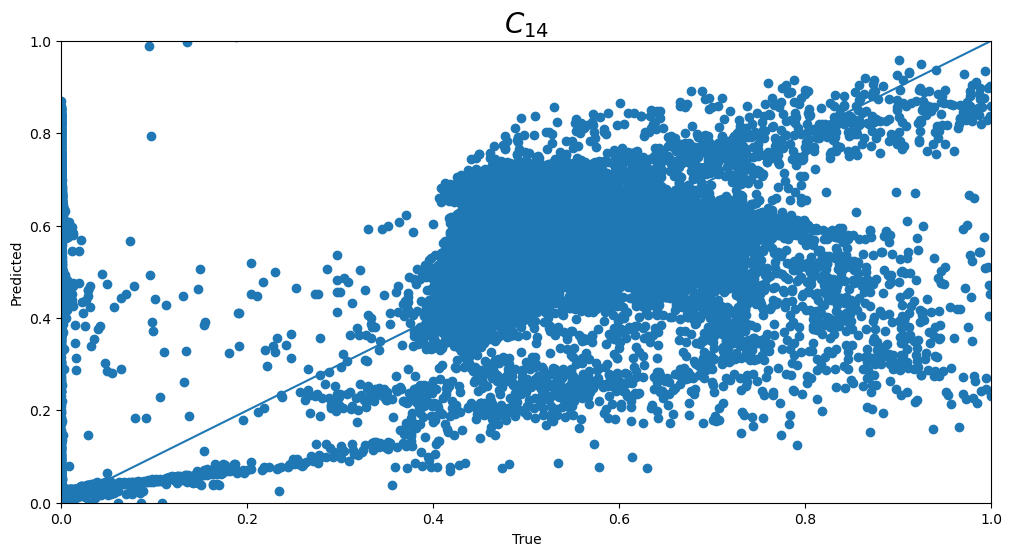

In [23]:
l1='Predicted'
l2='True'
nvar=1
# z=zt[0,:]
y_text=r'$C_{14}$'

# fig1,ax1 = plt.subplots(1,nvar,figsize = (12, 6))
fig2,ax2 = plt.subplots(1,nvar,figsize = (12, 6));
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin,xmax=ax2.get_xlim()
ymin,ymax=ax2.get_ylim()
ax2.plot([xmin,xmax],[xmin,xmax])
ax2.set_xlim([xmin,xmax])
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text,fontsize=20)

In [24]:
# ax1.plot(r2,z,'b',linewidth=2)
# ax1.set_title(y_text,fontsize=20)
# ax1.set_xlabel(r'R$^2$',fontsize=20)
# ax1.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# print("Avg. across all levels for "+y_text)
# print("R^2: %.4f" % np.mean(r2) )
# print("Correlation: %.4f" % +np.mean(r)+"\n")          

# for it in range(y_pred.shape[0]):
#     ax3.plot(y_pred[it],z,'r',label=l1)
#     ax3.plot(y_test[it],z,'k',label=l2)
#     l1,l2='__nolegend__','__nolegend__'
#     ax3.set_xlabel(y_text,fontsize=20)
#     ax3.set_ylabel(r'$z$',rotation=0,fontsize=20)

# # ax3.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# ax3[0].legend()
# l1='Predicted'
# l2='True'

In [25]:
# y_text=[r"$\overline{u'w'}/u_*^2$",r"$\overline{v'w'}/u_*^2$"]
# y_text=["U2DFSN","V2DFSN"]
# y_text[r'C_{14}']
# fig1,fig2,fig3=quickPlots(model,test_dataset,y_text,device)

In [26]:
# model.to("cpu")
# figure_fields=wandb.Image(plot_helpers.plot_fields(pyqg_dataset,model))
# wandb.log({"Fields": figure_fields})

In [27]:
# r2_upper,r2_lower,figure_power=metrics.get_offline_metrics(model,valid_loader)
# figure_power=wandb.Image(figure_power)
# wandb.log({"Power spectrum": figure_power})

In [28]:
# wandb.run.summary["r2_upper"]=r2_upper
# wandb.run.summary["r2_lower"]=r2_lower
# wandb.finish()